🧠 Depresión: (3077, 18)
💬 Distress: (3077, 30)

🔹 DEPRESIÓN ----------------------
🧹 Eliminadas 4 columnas altamente correlacionadas.
✅ PCA → 6 componentes reteniendo 96.73% varianza
✅ LassoCV → 10 features seleccionadas

🔹 DISTRESS ----------------------
🧹 Eliminadas 10 columnas altamente correlacionadas.
✅ PCA → 10 componentes reteniendo 96.38% varianza
✅ LassoCV → 16 features seleccionadas

📊 Resumen comparativo de reducción:


,Modelo,Features originales,Eliminadas por correlación,Componentes PCA (95%),Features Lasso,Varianza retenida (PCA)
0,Depresión,14,4,6,10,0.967337
1,Distress,26,10,10,16,0.963793


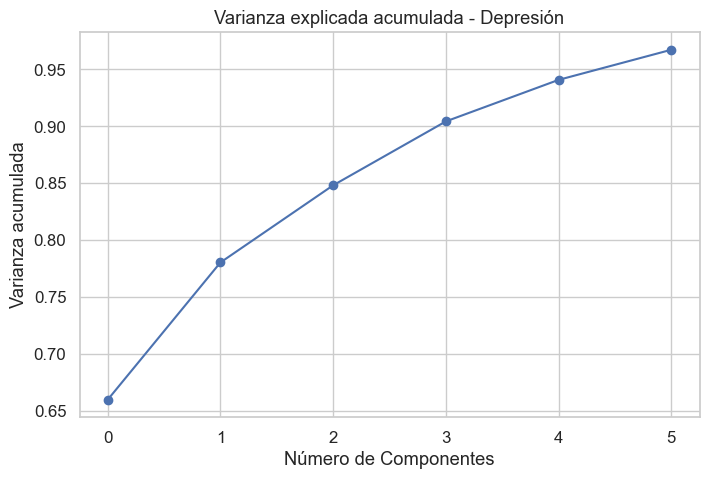

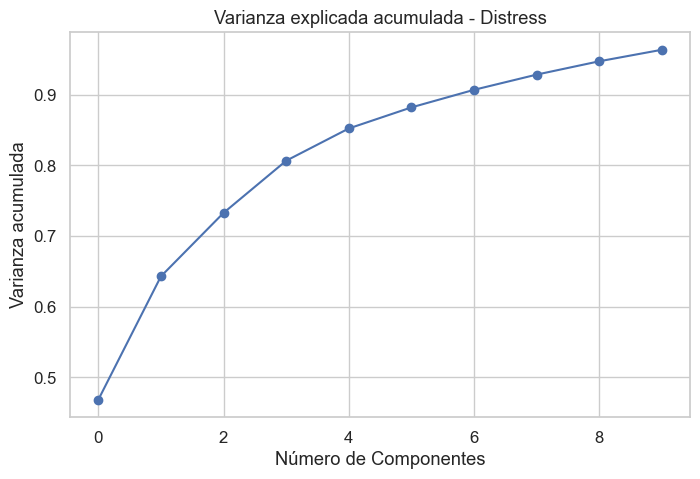


💾 Resultados guardados en ../data/interim/
   - feature_reduction_summary.csv
   - features_lasso_depression.csv
   - features_lasso_distress.csv

✅ Comparación PCA vs Lasso completada con éxito.


In [1]:
# 📓 Notebook: feature_reduction.ipynb
# 🎯 Objetivo: Comparar PCA y LassoCV para reducir dimensionalidad antes del modelado
# -------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8, 5)

# ==============================
# 1️⃣ Cargar datasets procesados
# ==============================
df_dep = pd.read_csv("../data/processed/model_data_depression_crudeprev.csv")
df_dis = pd.read_csv("../data/processed/model_data_mhlth_crudeprev.csv")

print("🧠 Depresión:", df_dep.shape)
print("💬 Distress:", df_dis.shape)

# Identificar columnas numéricas (excluyendo geográficas)
geo_cols = ["stateabbr", "statedesc", "locationname", "locationid"]
num_dep = df_dep.drop(columns=geo_cols, errors="ignore")
num_dis = df_dis.drop(columns=geo_cols, errors="ignore")

# ==============================
# 2️⃣ Función: Filtrar correlaciones altas (>0.9)
# ==============================
def drop_high_corr(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [c for c in upper.columns if any(upper[c] > threshold)]
    print(f"🧹 Eliminadas {len(to_drop)} columnas altamente correlacionadas.")
    return df.drop(columns=to_drop), to_drop

# ==============================
# 3️⃣ Función: PCA
# ==============================
def apply_pca(X, variance_threshold=0.95):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=variance_threshold, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    explained = pca.explained_variance_ratio_.sum()
    print(f"✅ PCA → {X_pca.shape[1]} componentes reteniendo {explained:.2%} varianza")
    return X_pca, pca, explained

# ==============================
# 4️⃣ Función: LassoCV
# ==============================
def apply_lasso(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X_scaled, y)
    selected = X.columns[(lasso.coef_ != 0)]
    print(f"✅ LassoCV → {len(selected)} features seleccionadas")
    return selected, lasso

# ==============================
# 5️⃣ Reducir y comparar: Depresión
# ==============================
print("\n🔹 DEPRESIÓN ----------------------")
X_dep = num_dep.drop(columns=["depression_crudeprev"], errors="ignore")
y_dep = num_dep["depression_crudeprev"]

X_dep_filtered, dropped_dep = drop_high_corr(X_dep)

# PCA
X_dep_pca, pca_dep, var_dep = apply_pca(X_dep_filtered)

# Lasso
selected_dep, lasso_dep = apply_lasso(X_dep_filtered, y_dep)

# ==============================
# 6️⃣ Reducir y comparar: Distress
# ==============================
print("\n🔹 DISTRESS ----------------------")
X_dis = num_dis.drop(columns=["mhlth_crudeprev"], errors="ignore")
y_dis = num_dis["mhlth_crudeprev"]

X_dis_filtered, dropped_dis = drop_high_corr(X_dis)

# PCA
X_dis_pca, pca_dis, var_dis = apply_pca(X_dis_filtered)

# Lasso
selected_dis, lasso_dis = apply_lasso(X_dis_filtered, y_dis)

# ==============================
# 7️⃣ Resumen comparativo
# ==============================
summary = pd.DataFrame({
    "Modelo": ["Depresión", "Distress"],
    "Features originales": [X_dep.shape[1], X_dis.shape[1]],
    "Eliminadas por correlación": [len(dropped_dep), len(dropped_dis)],
    "Componentes PCA (95%)": [X_dep_pca.shape[1], X_dis_pca.shape[1]],
    "Features Lasso": [len(selected_dep), len(selected_dis)],
    "Varianza retenida (PCA)": [var_dep, var_dis]
})

print("\n📊 Resumen comparativo de reducción:")
display(summary)

# ==============================
# 8️⃣ Gráfico varianza PCA
# ==============================
for name, pca, X in [("Depresión", pca_dep, X_dep_filtered), ("Distress", pca_dis, X_dis_filtered)]:
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.title(f"Varianza explicada acumulada - {name}")
    plt.xlabel("Número de Componentes")
    plt.ylabel("Varianza acumulada")
    plt.grid(True)
    plt.show()

# ==============================
# 9️⃣ Guardar resultados
# ==============================
summary.to_csv("../data/interim/feature_reduction_summary.csv", index=False)
pd.Series(selected_dep).to_csv("../data/interim/features_lasso_depression.csv", index=False)
pd.Series(selected_dis).to_csv("../data/interim/features_lasso_distress.csv", index=False)

print("\n💾 Resultados guardados en ../data/interim/")
print("   - feature_reduction_summary.csv")
print("   - features_lasso_depression.csv")
print("   - features_lasso_distress.csv")

print("\n✅ Comparación PCA vs Lasso completada con éxito.")
